In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

In [2]:
image_dir = Path(r'E:\Art Images dataset\Art_Dataset_Clear')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [3]:
image_df

,Filepath,Label
0,E:\Art Images dataset\Art_Dataset_Clear\Foreig...,Foreign
1,E:\Art Images dataset\Art_Dataset_Clear\Foreig...,Foreign
2,E:\Art Images dataset\Art_Dataset_Clear\Foreig...,Foreign
3,E:\Art Images dataset\Art_Dataset_Clear\Foreig...,Foreign
4,E:\Art Images dataset\Art_Dataset_Clear\Foreig...,Foreign
...,...,...
17015,E:\Art Images dataset\Art_Dataset_Clear\Indian...,Indian
17016,E:\Art Images dataset\Art_Dataset_Clear\Indian...,Indian
17017,E:\Art Images dataset\Art_Dataset_Clear\Indian...,Indian
17018,E:\Art Images dataset\Art_Dataset_Clear\Indian...,Indian


In [4]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,E:\Art Images dataset\Art_Dataset_Clear\Foreig...,Foreign
1,E:\Art Images dataset\Art_Dataset_Clear\Foreig...,Foreign
2,E:\Art Images dataset\Art_Dataset_Clear\Foreig...,Foreign


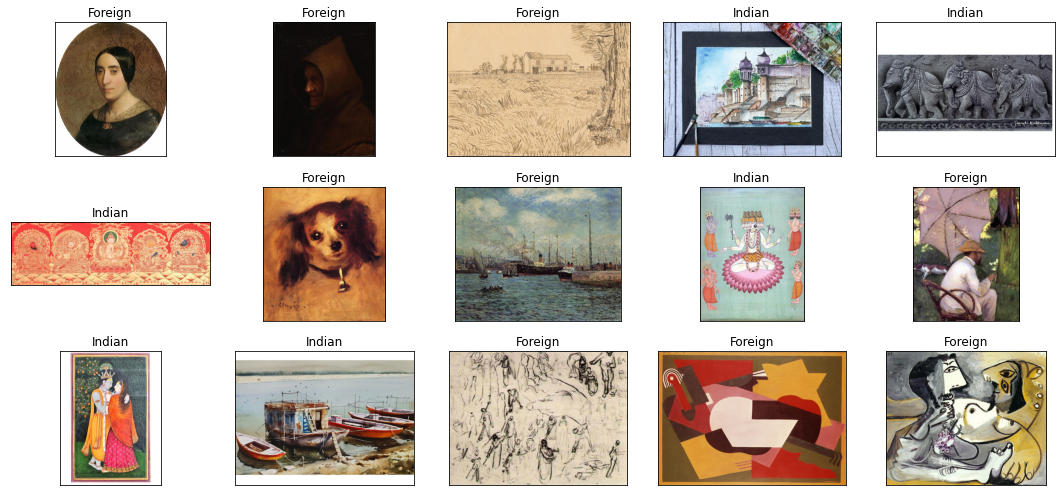

In [5]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [6]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 12255 validated image filenames belonging to 2 classes.
Found 3063 validated image filenames belonging to 2 classes.
Found 1702 validated image filenames belonging to 2 classes.


In [9]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [10]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
 37/383 [=>............................] - ETA: 11:49 - loss: 0.3470 - accuracy: 0.8462

C:\Users\udays\AppData\Roaming\Python\Python39\site-packages\PIL\Image.py:3011: DecompressionBombWarning: Image size (131768000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


345/383 [==========================>...] - ETA: 1:23 - loss: 0.2140 - accuracy: 0.9150

C:\Users\udays\AppData\Roaming\Python\Python39\site-packages\PIL\Image.py:3011: DecompressionBombWarning: Image size (97433616 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


383/383 [==============================] - 1036s 3s/step - loss: 0.2141 - accuracy: 0.9148 - val_loss: 0.1612 - val_accuracy: 0.9435
Epoch 2/50
383/383 [==============================] - 631s 2s/step - loss: 0.1256 - accuracy: 0.9542 - val_loss: 0.1292 - val_accuracy: 0.9533
Epoch 3/50
383/383 [==============================] - 631s 2s/step - loss: 0.0925 - accuracy: 0.9653 - val_loss: 0.1197 - val_accuracy: 0.9559
Epoch 4/50
383/383 [==============================] - 627s 2s/step - loss: 0.0603 - accuracy: 0.9779 - val_loss: 0.1248 - val_accuracy: 0.9514


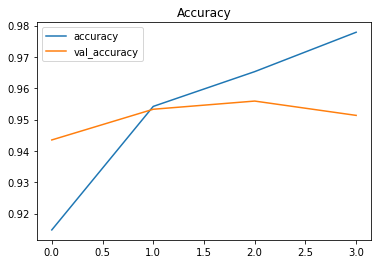

In [11]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

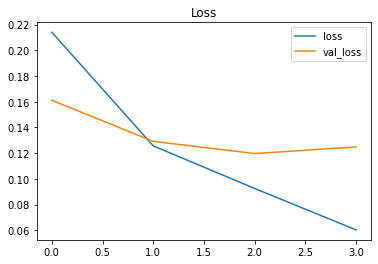

In [12]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [13]:
history.history

{'loss': [0.21405458450317383,
  0.12563467025756836,
  0.09251029044389725,
  0.060259077697992325],
 'accuracy': [0.914810299873352,
  0.9542227387428284,
  0.9653202891349792,
  0.9778865575790405],
 'val_loss': [0.16117683053016663,
  0.12915080785751343,
  0.1196753978729248,
  0.12483502924442291],
 'val_accuracy': [0.9435194134712219,
  0.9533137679100037,
  0.9559255838394165,
  0.9513548612594604]}

In [14]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.11823
Test Accuracy: 95.06%


In [15]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

In [16]:
model.predict(test_images)

array([[9.9268544e-01, 7.3145055e-03],
       [9.8965502e-01, 1.0344972e-02],
       [8.9858574e-01, 1.0141428e-01],
       ...,
       [9.9991429e-01, 8.5747379e-05],
       [3.1984982e-05, 9.9996805e-01],
       [9.9993300e-01, 6.6989320e-05]], dtype=float32)

In [17]:
pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [18]:
train_images.class_indices

{'Foreign': 0, 'Indian': 1}

In [19]:
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [20]:
labels.items()

dict_items([(0, 'Foreign'), (1, 'Indian')])

In [21]:
labels

{0: 'Foreign', 1: 'Indian'}

In [22]:
# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Foreign', 'Foreign', 'Foreign', 'Foreign', 'Foreign']


In [23]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     Foreign       0.97      0.96      0.96      1175
      Indian       0.91      0.93      0.92       527

    accuracy                           0.95      1702
   macro avg       0.94      0.95      0.94      1702
weighted avg       0.95      0.95      0.95      1702



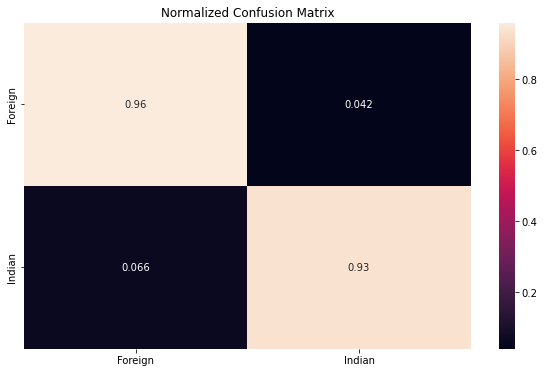

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

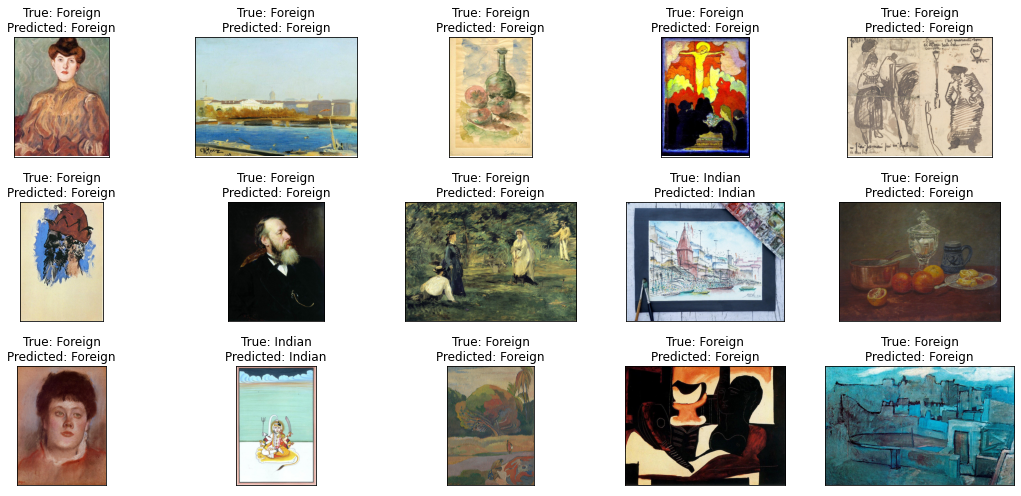

In [25]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [26]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

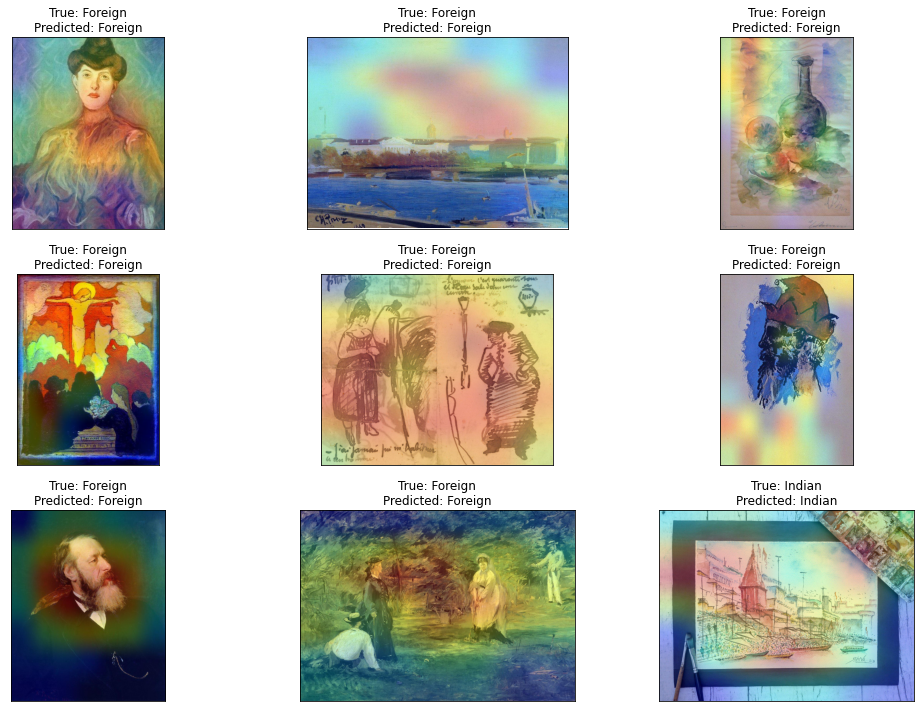

In [27]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [28]:
#testing the model

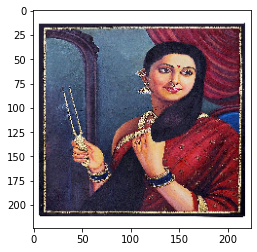

In [29]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img=image.load_img(r'E:\Art Images dataset\Art_Dataset_Clear\Indian\I (353).jpg',target_size=(224,224))

img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)

In [30]:
img.shape

(1, 224, 224, 3)

In [31]:
np.argmax(model.predict(img), axis=-1)

array([1], dtype=int64)

In [45]:
model.predict(img)

array([[-2.5725222,  2.705559 ]], dtype=float32)

In [32]:
output = np.argmax(model.predict(img), axis=-1)

In [33]:
import os
classes=r'E:\Art Images dataset\Art_Dataset_Clear'
my_dirs=[d for d in os.listdir(classes) if os.path.isdir(os.path.join(classes,d))]

In [34]:
my_dirs[output[0]]

'Indian'

In [35]:
#model.save('art.h5')

In [36]:
model.save('newart.h5')

In [37]:
output

array([1], dtype=int64)